In [27]:
# imports
from skimage.filters import threshold_otsu, rank
from skimage.util import img_as_ubyte
from skimage.io import imread,imsave
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import skimage as sk
from skimage.morphology import *
from helpers import *
from preprocessing import *
%matplotlib inline

In [28]:
def get_skeleton(_input_img, reverse_bin=False):
    input_img = np.copy(_input_img)
    # convert to grey scale
    input_img = input_img.astype(np.float64) / np.max(input_img)
    input_img = 255 * input_img
    input_img = input_img.astype(np.uint8)

    # binarization
    input_img = binarization(input_img)

    # remove noise
    input_img = binary_dilation(input_img)
    input_img = binary_erosion(input_img)

    # calculate the skeleton
    skeleton_img = sk.morphology.skeletonize(input_img)
    skeleton_img = skeleton_img*1
    if reverse_bin:
        skeleton_img = skeleton_img == 0
        skeleton_img = skeleton_img*1
    return skeleton_img

In [37]:
def get_LVL(skeleton_img,lineThresholdFraction=0.2):
    result = np.zeros(skeleton_img.shape)
    rows,cols = result.shape
    featureVector = []
    verticalLines = []
    for col in range(cols):
        cnt = 0
        tempCnt = 0
        l,r = -1,-1
        tl,tr = -1,-1
        minl,maxr = 1e9,0
        for row in range(rows):
            if skeleton_img[row,col] == 1:
                tempCnt += 1
                minl = min(minl,row)
                maxr = max(maxr,row)
                if tl == -1:
                    tl = row
                else:
                    tr = row
            else:
                if tempCnt > cnt:
                    l,r=tl,tr
                    cnt = tempCnt
                tempCnt = 0
        if cnt > rows*lineThresholdFraction:
            verticalLines.append(cnt)
            result[l:r+1,col] = 1
    verticalLines = np.array(verticalLines)
    if verticalLines.shape[0] == 0:
        verticalLines = np.append(verticalLines,0)
    featureVector.append(maxr-minl+1) # text height
    featureVector.append(verticalLines.shape[0]) # number of lines
    featureVector.append(np.max(verticalLines)) # longest line
    featureVector.append(np.max(verticalLines)/(maxr-minl+1)) # ratio between longest line and text height
    featureVector.append(np.var(verticalLines)) # variance among lines
    return featureVector,result

VL for kufi [-999999999.0, 18, 94, -9.4000000094e-08, 243.4444444444444]


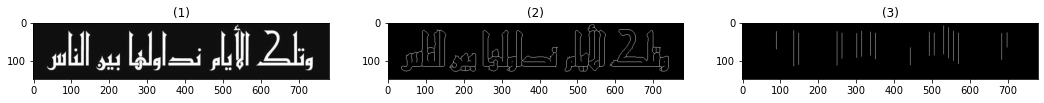

VL for skufi [-999999999.0, 18, 145, -1.45000000145e-07, 1138.138888888889]


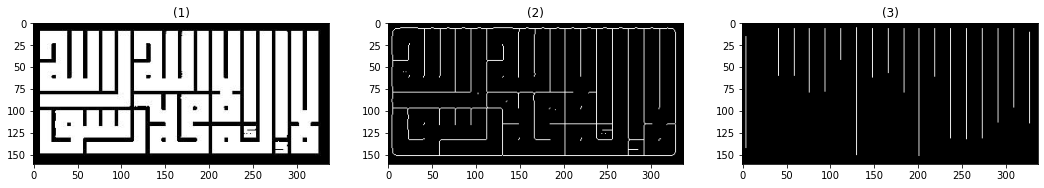

VL for other [3, 1, 0.0, 0.0, 0.0]


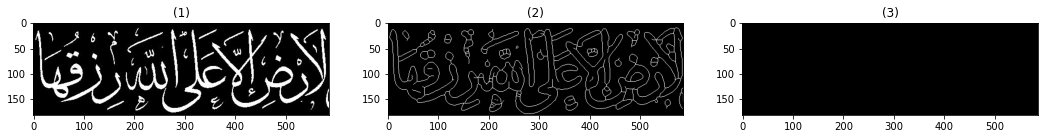

In [38]:
# read image
kufi_img = imread("./ACDB/ACdata_base/7/1128.jpg", as_gray=True)
skufi_img = imread("./ACDB/ACdata_base/9/1550.jpg", as_gray=True)
other_img = imread("./ACDB/ACdata_base/5/781.jpg", as_gray=True)

img = get_skeleton(kufi_img) 
img2 = get_skeleton(skufi_img) 
img3 = get_skeleton(other_img) 

arr1,vl1=get_LVL(img)
print("VL for kufi",arr1)
show_images([kufi_img,img,vl1])

arr2,vl2=get_LVL(img2)
print("VL for skufi",arr2)
show_images([skufi_img,img2,vl2])

arr3,vl3=get_LVL(img3)
print("VL for other",arr3)
show_images([other_img,img3,vl3])